In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import copy

In [2]:
#define a simple ode solver

In [3]:
def EulerSolve(t0, t1, x0, f, dt = 0.01, reverse=False):
    #f(z, t)
    
    ts = np.arange(t0, t1, dt)
    if reverse:
        ts = np.arange(t1, t0, -dt)
    
    z = x0.copy()
    
    for t in ts:
        
        if not reverse:
            z+= dt*f(z, t)
        else:
            z-= dt*f(z, t)
        #print(z)
    return z

In [4]:
#test
EulerSolve(0, np.pi, np.array([0., 1.]), f, dt = 0.01)

NameError: name 'f' is not defined

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from functools import reduce
import operator

first define a class to hold the neural network component of the dynamical function

In [7]:
class DynamicNN(nn.Module):
    def __init__(self):
        super().__init__()
        #lets try a simple model
        self.f = nn.Linear(2, 2, bias=False)
        self.p_shapes = None
    
    def forward(self, x):
        return self.f(x)
    
    def get_jacobian(self, x, out_type='numpy'):
        """
        This is a sort of a misapplication of the 
        use of batches. Here we make a batch of 
        n copies of the data, one for each 
        of the function outputs. We take the gradient
        of each of the outputs, and recombine to get
        the jacobian
        """
        #x should be a torch tensor of shape
        #(len x + len a + len a_p)
        
        #self.zero_grad()
        
        noutputs = x.shape[-1]
        x = x.repeat(noutputs, 1)
        
        x.requires_grad_(True)
        y = self.f(x)
        y.backward(torch.eye(noutputs))
        
        if out_type == 'numpy':
            return x.grad.data.detach().numpy()
        else:
            return x.grad.data
    
    def get_parameter_jacobian(self, x, out_type='numpy'):
        """
        I dont know a way to do this rapidly
        lets do a repetition for each output
        """
        
        noutputs = x.shape[-1]
        param_grads = []
        
        for out_index in range(noutputs):
            y=self.f(x)
            
            #set grads to zero so they dont accumulate
            for p in self.parameters():
                if type(p.grad) != type(None):
                    p.grad.zero_()
            
            #backprop
            y[out_index].backward()
            
            #now get grads and flatten them 
            param_grads.append(self.flatten_param_grads())
        
        
        #print("p jacob",param_grads)
        
        if out_type == 'numpy':
            return torch.stack(param_grads).detach().numpy()
        else:
            return torch.stack(param_grads)
    
    def flatten_param_grads(self):
        """
        return the grads of the parameters
        which have been systematically and 
        replicably flattened
        """
        self.p_shapes = []
        self.flat_params = []
        
        with torch.no_grad():
            for p in self.parameters():
                self.p_shapes.append(p.size())
                self.flat_params.append(p.grad.flatten())
        
        return torch.cat(self.flat_params)
    
    def unflatten_param_grads(self, grads):
        """
        restore the param grads to their original shapes
        
        set param grads equal to grads
        
        grads can be either array or tensor
        this converts them to tensors before working with them
        """
        assert(len(grads.shape)==1)
        
        #ensure we have a tensor
        grads = torch.tensor(grads, dtype=torch.float32)
        
        count=0
        with torch.no_grad():
            for i, p in enumerate(self.parameters()):

                shape = self.p_shapes[i]
                size = reduce(operator.mul, shape, 1)
                
                #to be safe, if this has a gradient already, 
                #remove it
                if type(p.grad)!= type(None):
                    p.grad.zero_()
                
                #now assign it the appropriate gradient
                p.grad = grads[count:count+size].view(shape)
                
                #print('grad',i,p.grad)
                #print(p.grad)

                count += size
        assert(count == len(grads))
        
    def descend(self, lr):
        """
        descend weights by grads multiplied by dx
        """
        with torch.no_grad():
            for param in self.parameters():
                param -= param.grad*lr

Supposing this is our dynamical function, we then have

$$
\frac{d x}{d t} = M.x
$$

We'll have our goal to be to get $x$ to $x'$ after time T

So we have a single data point

now well build a class that implements the adjoint method.

In [16]:
class AdjointMethod():
    def __init__(self, DynamicNN, ODESolver):
        """
        this will implement the augmented adjoint 
        method
        
        DynamicNN is of the DynamicNN class 
        
        loss_func: x-> Reals
        
        ODESolver is a function of the form
        ODESolver(t0, t1, x0, f, reverse=False)
        """
        self.nn = DynamicNN
        self.ODESolver = ODESolver
        #next we define the function which returns the dynamics of the position
        self.func = lambda x, t: self.nn.forward(torch.from_numpy(x).float()).detach().numpy()
        self.target_set=False
        self.param_num=None
        
    def forward(self, t0, t1, x0):
        """
        calculate the forward pass, obtain x1
        """
        #print('forward start x0:', x0)
        self.t0=t0
        self.t1=t1
        self.x0= x0.astype(float)
        
        """
        #next we define the function which returns the dynamics of the position
        self.func = lambda x, t: self.nn.forward(torch.from_numpy(x).float()).detach().numpy()
        """
        
        x1=self.ODESolver(t0, t1, x0.astype(float), self.func, reverse=False)
        
        #print(EulerSolve(t0, t1, x0, self.func, dt = 0.01, reverse=False))
        
        self.x1 = x1
        #print('forward end x0:', x0)
        return x1
    
    def dynamical_function(self, x,t):
        """
        runs dynamical function on x, t
        without using gradients
        """
        with torch.no_grad():
            vec = self.func(x, t)
        return vec
    
    def set_target(self, target, loss_function):
        """
        target is a numpy array, or pytorch tensor
        loss function is a pytorch function
        
        set the target, and the loss function
        the loss function is a function of two points (x1, x2)
        """
        
        
        #make sure type of x0 is a tensor
        self.target = torch.tensor(target).float()
        
        #set loss function
        self.loss_func = lambda x: loss_function(x, self.target)
        
        self.target_set=True
        
    
    def GiveDynamical(self):
        """
        d[z, a, a_p]/dt = [f, -a f_z, -a f_p]
        
        here we return a function which gives the rhs
        """
        
        def AdjointDynamical(a_aug, t):
            """
            here a_aug is given by 
            [z, a, a_p]
            and evolves according to 
            d[z, a, a_p]/dt = [f, -a f_z, -a f_p]
            
            When this is implemented, we run it backwards
            
            """
            
            x = a_aug[:self.x0.shape[0]]
            tensor_x = torch.tensor(x).float()
            a = a_aug[self.x0.shape[0]:2*self.x0.shape[0]]
            ap = a_aug[2*self.x0.shape[0]]
            
            assert(a.shape[-1]==x.shape[-1])
            
            #print('tensor_x', tensor_x)
            
            f_p = self.nn.get_parameter_jacobian(tensor_x, out_type='numpy')
            af_p = a @ f_p
            
            f_z = self.nn.get_jacobian(tensor_x, out_type='numpy')
            af_z = a @ f_z
            
            #print('parts of aug dynamical')
            #print(self.func(x, t))
            #print('a dyn', -af_z)
            #print('ap dyn', -af_p)
            
            with torch.no_grad():
                z_t = self.func(x, t)
            
            return np.concatenate([z_t, -af_z, -af_p])
        
        return AdjointDynamical
    
    def SetInitialConditions(self):
        """
        assuming forward has been run, this loads the initial conditions
        for d[a, a_p]/dt = [-a f_z, -a f_p]
        
        note this is run backwards, from t1 to t0
        
        the initial conditions are [dL(z1)/d z1, 0]
        since the loss is defined at L(z1)
        """
        #print('x0 is:', self.x0)
        
        #first obtain a0 = dl/dz
        x1_tensor = torch.tensor(self.x1).float().requires_grad_()
        #print('x1 is',x1_tensor)
        
        loss = self.loss_func(x1_tensor)
        
        loss.backward()
        
        dldz = (x1_tensor.grad.data).detach().numpy()
        
        #print('dldz',dldz)
        
        assert(dldz.shape == self.x1.shape)
        
        #now a_p0 = 0, so we need a zero array with length equal to 
        #the number of parameters
        if not self.param_num:
            self.param_num=0
            for param in self.nn.parameters():
                self.param_num+=reduce(operator.mul, param.shape, 1)
        
        a_p0 = np.zeros(self.param_num)
        
        #put it all together
        self.InitialConditions = np.concatenate([self.x1, dldz, a_p0])
        
        return self.InitialConditions
    
    def AjointSensitivity(self, t0, t1, x0, lr):
        """
        here we'll enact the adjoint method to determine the gradient 
        we'll do this by solving the adjoint differential equation
        
        we also use initial conditions
        this requires an initial pass of forward to save x1 in memory
        """
        
        
        #assert that the target and the loss function
        #have been set
        assert(self.target_set)
        
        #first we do a forward pass
        #this determines the x1 point
        with torch.no_grad():
            self.forward(t0, t1, x0)
        
        #now obtain the dynamical function telling us how
        #to solve the adjoint ode
        dynamic_f = self.GiveDynamical()
        
        #set the initial conditions for the adjoint
        #dynamics
        self.SetInitialConditions()
        
        #Next solve the adjoint ode
        a0 = self.ODESolver(
            t0, 
            t1, 
            self.InitialConditions, 
            dynamic_f,  
            reverse=True)
       
        #print('a0: x0, dldz(t0), dldp: ',a0)
        #print('x0:', self.x0)
        
        #a0 is of the form [z(t0), dL/dz(t0), dL/dp]
        #now all but the first 2*z.shape[0] are dL/dp
        flat_dldp = a0[2*self.x0.shape[0]:]
        
        #now we set the parameter grads to reflect the above gradient
        self.nn.unflatten_param_grads(flat_dldp)
        
        #now we descend
        self.nn.descend(lr)
    
    def zero_grad(self):
        """
        shortcut to clear grads from neural network
        """
        with torch.no_grad():
            for param in self.nn.parameters():
                param.grad.zero_()
    
    def get_loss(self):
        """
        returns scalar of loss
        assumes forward has been run, and target has been set
        """
        assert(self.target_set)
        
        return self.loss_func(torch.tensor(self.x1).float()).detach().numpy()
    
    def copy_model(self):
        """
        return a copy of the model
        """
        return copy.deepcopy(self.nn)

In [17]:
def stream(xmin, xmax, ymin, ymax, dynamic_f):
    """
    dynamic_f is a function of x,y
    returns a 2d vector
    """
    
    Y, X = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    
    U, V = np.zeros((100, 100)), np.zeros((100, 100))
    
    for i, x in enumerate(X[0]):
        for j, y in enumerate(Y[0]):
            U[i, j], V[i, j] = dynamic_f(x, y)

    plt.streamplot(X, Y, U, V, color=U, linewidth=2, cmap=plt.cm.cool)
    plt.colorbar()

In [18]:
tnn = DynamicNN()

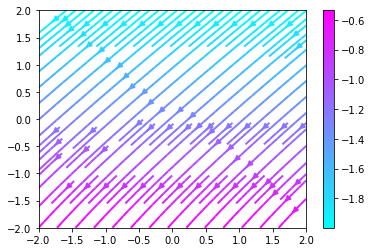

In [19]:
stream(-2, 2, -2, 2, lambda x, y: adjm.dynamical_function(np.array([x,y]), 1))

In [20]:
#define adjoint method object
adjm = AdjointMethod(tnn, EulerSolve)
#set target and loss
target = np.array([0.,1.])
loss_function = nn.functional.mse_loss
adjm.set_target(target, loss_function)

In [21]:
#set learning parameters
t0=0
t1=1
#initial point
x0=np.array([1., 0.])
lr = .1

In [22]:
losses=[]

In [23]:
#procedure
for _ in range(250):
    adjm.AjointSensitivity(t0, t1, ccccc, lr)
    adjm.zero_grad() #this may not be necessary, not sure
    #but it doesnt hurt
    losses.append(adjm.get_loss())
    

NameError: name 'ccccc' is not defined

In [24]:
print(adjm.x1)

AttributeError: 'AdjointMethod' object has no attribute 'x1'

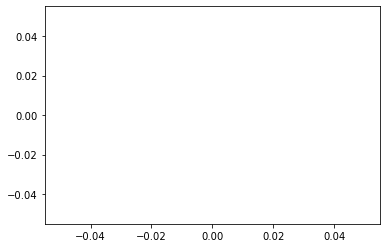

In [25]:
plt.plot(losses)

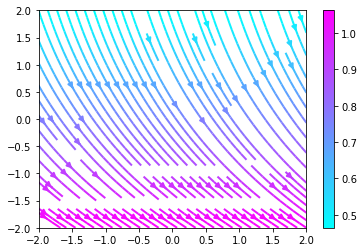

In [26]:
stream(-2, 2, -2, 2, lambda x, y: adjm.dynamical_function(np.array([x,y]), 1))

In [2081]:
for p in adjm.nn.parameters():
    print(p)

Parameter containing:
tensor([[-1.1834, -0.8317],
        [ 1.1492,  0.8713]], requires_grad=True)
